In [ ]:
import numpy as np
import pandas as pd

import keras
from keras.layers.merge import add
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

import nltk
from nltk.corpus import stopwords

import re
import string
import json
from time import time
import pickle

import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!unzip "/content/gdrive/My Drive/Flickr8k/Flickr8k_Dataset.zip"
!unzip "/content/gdrive/My Drive/Flickr8k/Flickr8k_text.zip"

caption_file = "Flickr8k.token.txt"

captions = []
with open(caption_file) as f:
  captions = f.readlines()

captions = [x.strip() for x in captions]

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/Flicker8k_Dataset/._3429465163_fb8ac7ce7f.jpg  
  inflating: Flicker8k_Dataset/3429581486_4556471d1a.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429581486_4556471d1a.jpg  
  inflating: Flicker8k_Dataset/3429641260_2f035c1813.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429641260_2f035c1813.jpg  
  inflating: Flicker8k_Dataset/3429956016_3c7e3096c2.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429956016_3c7e3096c2.jpg  
  inflating: Flicker8k_Dataset/3430100177_5864bf1e73.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430100177_5864bf1e73.jpg  
  inflating: Flicker8k_Dataset/3430287726_94a1825bbf.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430287726_94a1825bbf.jpg  
  inflating: Flicker8k_Dataset/3430526230_234b3550f6.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430526230_234b3550f6.jpg  
  inflating: Flicker8k_Dataset/3430607596_7e4f74e3ff.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430

In [ ]:
captions[:10]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .']

In [ ]:
descriptions = {}

for x in captions:
    imgid, cap = x.split('\t')
    imgid = imgid.split('.')[0]
    
    if imgid not in descriptions.keys():
        descriptions[imgid] = []
    
    descriptions[imgid].append(cap)

In [ ]:
for key, caps in descriptions.items():
    for i in range(len(caps)):
        caps[i] = caps[i].lower()
        caps[i] = re.sub("[^a-z]+", " ", caps[i])

In [ ]:
allwords = []

for key in descriptions.keys():
    _ = [allwords.append(i) for cap in descriptions[key] for i in cap.split()]

In [ ]:
from collections import Counter

freq = dict(Counter(allwords))
freq = sorted(freq.items(), reverse=True, key=lambda x:x[1])

threshold = 15
freq = [x for x in freq if x[1]>threshold]

print(len(freq))

1493


In [ ]:

freq[:10]

[('a', 62995),
 ('in', 18987),
 ('the', 18420),
 ('on', 10746),
 ('is', 9345),
 ('and', 8863),
 ('dog', 8138),
 ('with', 7765),
 ('man', 7275),
 ('of', 6723)]

In [ ]:
allwords = [x[0] for x in freq]

In [ ]:
train_file = "/content/Flickr_8k.trainImages.txt"
test_file = "/content/Flickr_8k.testImages.txt"

In [ ]:
with open(train_file) as f:
    cap_train = f.readlines()

cap_train = [x.strip() for x in cap_train]

In [ ]:
with open(test_file) as f:
    cap_test = f.readlines()

cap_test = [x.strip() for x in cap_test]

In [ ]:
train = [row.split(".")[0] for row in cap_train]
test = [row.split(".")[0] for row in cap_test]

In [ ]:
train_desc = {}
max_caption_len = -1

for imgid in train:
    train_desc[imgid] = []
    for caption in descriptions[imgid]:
        train_desc[imgid].append("#START# " + caption + " #STOP#")
        max_caption_len = max(max_caption_len, len(caption.split())+1)

In [ ]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3))
model.summary()

102973440/102967424 [==============================] - 2s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

In [ ]:
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
def encode_img(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    
    img = preprocess_input(img)
    feature_vector = model_new.predict(img)
    
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [ ]:
img_data = "/content/Flicker8k_Dataset"

In [ ]:
train_encoded = {}

for ix, imgid in enumerate(train):
    img_path = img_data + "/" + imgid + ".jpg"
    
    train_encoded[imgid] = encode_img(img_path)
    
    if ix%100 == 0:
        print(".", end="")

............................................................

In [ ]:
train_encoded["2513260012_03d33305cf"]

array([0.34707937, 0.51159155, 0.08728858, ..., 1.1897289 , 0.04043857,
       0.15271065], dtype=float32)

In [ ]:
len(test)

1000

In [ ]:
test_encoded = {}

for i, imgid in enumerate(test):
    img_path = img_data + "/" + imgid + ".jpg"
    
    test_encoded[imgid] = encode_img(img_path)
    
    if i%100 == 0:
        print(".", end="")

..........

In [ ]:
word_index_map = {}
index_word_map = {}

for i,word in enumerate(allwords):
    word_index_map[word] = i+1
    index_word_map[i+1] = word

In [ ]:

index_word_map[len(index_word_map)] = "#START#"
word_index_map["#START#"] = len(index_word_map)

index_word_map[len(index_word_map)] = "#STOP#"
word_index_map["#STOP#"] = len(index_word_map)

In [ ]:
f = open("/content/gdrive/My Drive/Colab Notebooks/glove.6B.50d.txt", encoding='utf8')

In [ ]:
embeddings = {}

for line in f:
    words = line.split()
    word_embeddings = np.array(words[1:], dtype='float')
    
    embeddings[words[0]] = word_embeddings

In [ ]:
f.close()

In [ ]:
embeddings['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [ ]:
embedding_matrix = np.zeros((len(word_index_map) + 1, 50))
for word, index in word_index_map.items():
    embedding_vector = embeddings.get(word)

    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(1496, 50)

In [ ]:
in_img_feats = Input(shape=(2048,))
in_img_1 = Dropout(0.3)(in_img_feats)
in_img_2 = Dense(256, activation='relu')(in_img_1)

In [ ]:
in_caps = Input(shape=(max_caption_len,))
in_cap_1 = Embedding(input_dim=len(word_index_map) + 1, output_dim=50, mask_zero=True)(in_caps)
in_cap_2 = Dropout(0.3)(in_cap_1)
in_cap_3 = LSTM(256)(in_cap_2)

In [ ]:
decoder_1 = add([in_img_2, in_cap_3])
decoder_2 = Dense(256, activation='relu')(decoder_1)
outputs = Dense(len(word_index_map) + 1, activation='softmax')(decoder_2)

model = Model(inputs=[in_img_feats, in_caps], outputs=outputs)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 37)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 37, 50)       74800       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
_______________________________________________________________________________________

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
def data_generator(train_descs, train_encoded, word_index_map, max_caption_len, batch_size):
    X1, X2, y = [], [], []
    
    n = 0
    while True:
        for key, desc_list in train_descs.items():
            n += 1
            
            photo = train_encoded[key]
            for desc in desc_list:
                
                seq = [word_index_map[word] for word in desc.split() if word in word_index_map]
                for i in range(1, len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    xi = pad_sequences([xi], maxlen=max_caption_len, value=0, padding='post')[0]
                    yi = to_categorical([yi], num_classes=len(word_index_map) + 1)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                
                if n==batch_size:
                    yield ([np.array(X1), np.array(X2)], np.array(y))
                    X1, X2, y = [], [], []
                    n = 0

In [ ]:
batch_size = 3
steps = len(train_desc)//batch_size

In [ ]:
generator = data_generator(train_desc, train_encoded, word_index_map, max_caption_len, batch_size)
model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
2000/2000 [==============================] - 55s 28ms/step - loss: 3.7561


In [ ]:
model.save('/content/gdrive/My Drive/Flickr8k/model.h5')
model = load_model('/content/gdrive/My Drive/Flickr8k/model.h5')

In [ ]:
def predict_caption(img):
    
    in_text = "#START#"
    for i in range(max_caption_len):
        sequence = [word_index_map[w] for w in in_text.split() if w in word_index_map]
        sequence = pad_sequences([sequence], maxlen=max_caption_len, padding='post')
        
        pred = model.predict([img, sequence])
        pred = pred.argmax()
        word = index_word_map[pred]
        in_text += (' ' + word)
        
        if word == "#STOP#":
            break
    
    caption = in_text.split()[1:-1]
    
    return ' '.join(caption)

a group of people are standing on a field


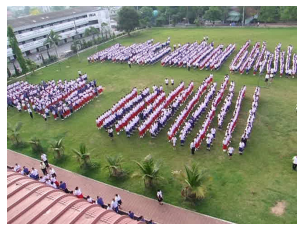

a black dog is running in the water


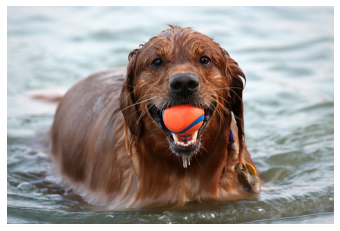

a man in a red shirt is standing on a bench


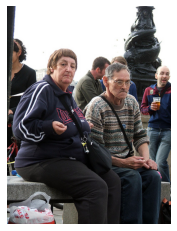

a little girl in a red shirt is running on a field


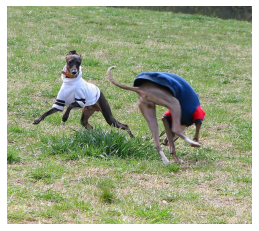

a little girl in a red shirt is running on a field


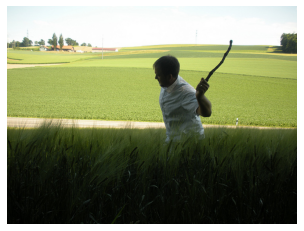

a man in a helmet is riding a bicycle on a dirt


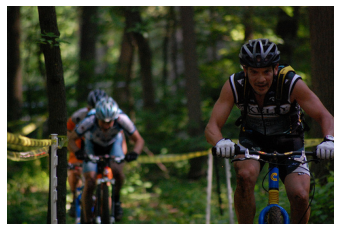

a man in a red shirt is jumping down a snowy hill


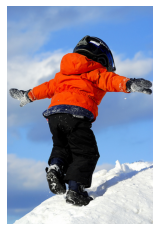

a man is jumping on a pool


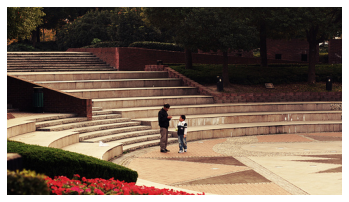

a dog is running in the water


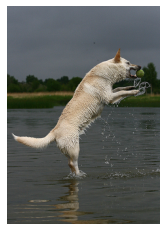

a dog is running on the beach


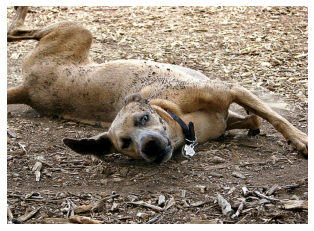

a dog is running on a field


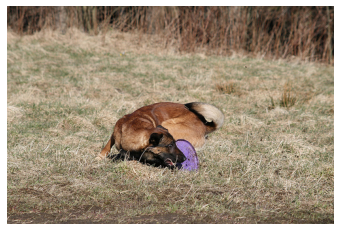

a man in a black shirt is standing on a bench


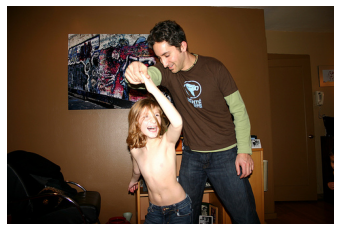

a dog is running on a field


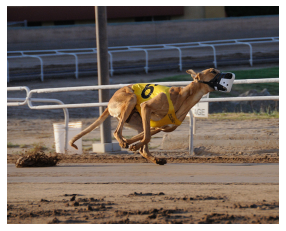

a man in a red shirt is standing on a bench


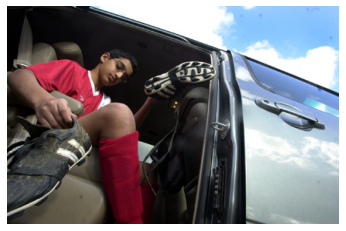

a man in a red shirt is standing on a field


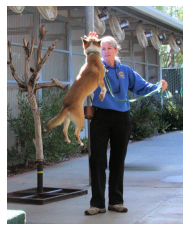

In [ ]:
for i in range(15):
    
    idx = np.random.randint(0, 1000)
    all_img_names = list(test_encoded.keys())
    img_name = all_img_names[idx]
    photo_2048 = test_encoded[img_name].reshape((1, 2048))

    i = plt.imread(img_data + '/' + img_name + '.jpg')
    caption = predict_caption(photo_2048)

    print(caption)
    plt.imshow(i)
    plt.axis('off')
    plt.show()